### Capstone Project: Reducing Crime in San Francisco, Part 1

by Elton Yeo, DSI13

#### Problem Statement and Context

Police departments have limited policy and frontline resources, and need to prioritise areas to focus their efforts to reduce crime, through greater prevention and/or deterrence. 

This project will analyse crime data for San Francisco city to: 
- develop insights into the areas with the most crimes, and consider policy and operational measures which might help to bring down crime in those areas based on those insights
- (understand which variables would result in the lowest number of crimes in an area?)
- predict the number and types of crime given a specific date, day of the week, and hour, which will help the police plan their patrol schedules and resources (Police patrols are important because they project presence, which can deter criminals and increase the sense of safety for residents) 

For the prediction, the data will be run through 3 regression models: linear regression, random forest, and XGBoost. 

The models will be trained on 2018 data, and tested on 2019 data, and evaluated by their r-sqaured scores. Success is defined as a r-sqaured score of 0.8 and above, which means that the model explains 80% or more of the variability of the target data that is predictable from the independent variables.

#### Risks and Assumptions of Data

The data may have been recorded in a manner that is useful for frontline officers or operators, thus impeding data cleaing and our understanding of the data. 

We assume that the data was recorded/provided accurately by the frontline officers or the citizens who had reported the crimes. 

Data source: https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783

#### Contents:
- [Data Cleaning](#Data-Cleaning)
- [Feature Engineering](#Feature-Engineering)
- [Data Dictionary](#Data-Dictionary)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)

In [776]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas
from shapely.geometry import Point
from pygeocoder import Geocoder

%matplotlib inline

### Data Cleaning

In [777]:
reports=pd.read_csv('../data/reports.csv')

In [778]:
#standardising column names, replacing the spaces with underscores
#...and converting all letters to lowercase 
reports.columns = reports.columns.str.replace(' ', '_').str.lower()

In [779]:
reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329469 entries, 0 to 329468
Data columns (total 36 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   incident_datetime                                     329469 non-null  object 
 1   incident_date                                         329469 non-null  object 
 2   incident_time                                         329469 non-null  object 
 3   incident_year                                         329469 non-null  int64  
 4   incident_day_of_week                                  329469 non-null  object 
 5   report_datetime                                       329469 non-null  object 
 6   row_id                                                329469 non-null  int64  
 7   incident_id                                           329469 non-null  int64  
 8   incident_number                             

We will remove the following variables:
- incident_datetime: since it repeats information found in incident_date and incident_time
- report_datetime: since this is not critical to the occurrence of the crime incident, and is only an administrative record of when the report of the incident was filed
- row_id: this is an identifier unique to the dataset; we do not need it since we have the index
- incident_id: this is an adminstrative number to keep track of the incidents, and is not critical to the occurrence of the crime incident
- incident_number: this is also an adminstrative number to keep track of incidents, and is not critical to the occurrence of the crime incident
- cad_number: this is an adminstrative number issued by the Dept of Emergency Management and is tagged to the incident_number; it is not critical to the occurrence of the crime incident
- report_type_code: this is a label for the report_type_description, and is not necessary
- incident_code: this is a label for incident_category, and is not necessary
- incident_subcategory: such level of detail is not necesary for the model
- incident_description: such level of detail is not necessary for the model
- intersection: this is the 2 or more street names that intersect closest to the original incident; it is not necessary since we will be using the longitude and latitude for the precise locations
- cnn: unique identifier of the intersection which can be removed
- point: point geometry used for mapping features in the open data portal platform which can be removed
- central_market/tenderloin_boundary_polygon_-_updated: used to indicate whether the incident took place within the boundaries of the tenderlion neighborhood or not; not necessary since we this repeats the other neighborhood data which we have
- esncag_-_boundary_file: marks whether the crime took place within the Embarcadero SAFE Navigation Center (ESNCAG) or not; can be dropped because the mode is very high which means it has less variance and will have little impact on the model
- sf_find_neighborhoods: refer to Neighborhood boundaries that were defined in 2006 by the Mayor's Office of Neighborhood Services for use with the SF Find tool; not necessary because analysis_neighborhood already tells us the neighborhood the incident took place in.
- analysis_neighborhoods: these are numbers which correspond to the neighborhood name found in the closely-named 'analysis_neighborhood' variable
- current_police_districts: these are numbers which correspond to the district name found in the 'police_district' variable
- supervisor_district: information is superseded by 'current_supervisor_districts'variable
- filed_online: indicates whether report was filed online or not; not necessary because information is already captured in 'report_type_description' variable

Sources: 
- https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783
- https://data.sfgov.org/dataset/ESNCAG-Boundary-File/8cs3-kxq7
- https://support.datasf.org/help/police-department-incident-reports-2018-to-present-overview

In [780]:
reports.drop(columns=['incident_datetime', 'report_datetime', 'row_id', 
                      'incident_id', 'incident_number', 'cad_number', 
                      'report_type_code', 'incident_code', 'incident_subcategory', 
                      'incident_description', 'intersection', 'cnn', 'point',
                     'central_market/tenderloin_boundary_polygon_-_updated',
                     'esncag_-_boundary_file', 'sf_find_neighborhoods', 
                     'analysis_neighborhoods', 'current_police_districts',
                     'supervisor_district', 'filed_online'], inplace=True)

In [781]:
reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329469 entries, 0 to 329468
Data columns (total 16 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   incident_date                      329469 non-null  object 
 1   incident_time                      329469 non-null  object 
 2   incident_year                      329469 non-null  int64  
 3   incident_day_of_week               329469 non-null  object 
 4   report_type_description            329469 non-null  object 
 5   incident_category                  329438 non-null  object 
 6   resolution                         329469 non-null  object 
 7   police_district                    329469 non-null  object 
 8   analysis_neighborhood              311736 non-null  object 
 9   latitude                           311801 non-null  float64
 10  longitude                          311801 non-null  float64
 11  current_supervisor_districts       3117

In [782]:
reports.head()

,incident_date,incident_time,incident_year,incident_day_of_week,report_type_description,incident_category,resolution,police_district,analysis_neighborhood,latitude,longitude,current_supervisor_districts,hsoc_zones_as_of_2018-06-05,owed_public_spaces,parks_alliance_cpsi_(27+tl_sites),"areas_of_vulnerability,_2016"
0,2019/05/01,01:00,2019,Wednesday,Initial,Offences Against The Family And Children,Open or Active,Taraval,Sunset/Parkside,37.762569,-122.499627,7.0,NaN,NaN,NaN,1.0
1,2019/06/22,07:45,2019,Saturday,Initial,Non-Criminal,Open or Active,Southern,South of Market,37.780535,-122.408161,10.0,1.0,NaN,NaN,2.0
2,2019/06/03,16:16,2019,Monday,Initial Supplement,Missing Person,Open or Active,Bayview,Bayview Hunters Point,37.721600,-122.390745,9.0,NaN,NaN,NaN,2.0
3,2018/11/16,16:34,2018,Friday,Initial Supplement,Offences Against The Family And Children,Cite or Arrest Adult,Central,Chinatown,37.794860,-122.404876,3.0,NaN,18.0,NaN,2.0
4,2019/05/27,02:25,2019,Monday,Initial,Assault,Open or Active,Northern,Marina,37.797716,-122.430559,6.0,NaN,NaN,NaN,1.0


In [783]:
reports.isnull().sum()

incident_date                             0
incident_time                             0
incident_year                             0
incident_day_of_week                      0
report_type_description                   0
incident_category                        31
resolution                                0
police_district                           0
analysis_neighborhood                 17733
latitude                              17668
longitude                             17668
current_supervisor_districts          17729
hsoc_zones_as_of_2018-06-05          256150
owed_public_spaces                   312783
parks_alliance_cpsi_(27+tl_sites)    325387
areas_of_vulnerability,_2016          17794
dtype: int64

#### Imputing null values: 'incident_category'

For 'incident_category', there is a small amount of null values which do not identify the type of incident it was. We will include these under 'Other'.

In [784]:
reports[['incident_category']][reports.incident_category.isnull()]

,incident_category
7938,NaN
8536,NaN
8597,NaN
8689,NaN
8758,NaN
11274,NaN
11291,NaN
11416,NaN
12873,NaN
14377,NaN


In [785]:
reports.incident_category.fillna('Other', inplace=True)

In [786]:
reports.incident_category.value_counts()

Larceny Theft                                   106253
Other Miscellaneous                              24506
Non-Criminal                                     20373
Malicious Mischief                               19600
Assault                                          19500
Burglary                                         14315
Warrant                                          12063
Lost Property                                    12042
Motor Vehicle Theft                              11768
Fraud                                             9784
Recovered Vehicle                                 9526
Drug Offense                                      8473
Robbery                                           7825
Missing Person                                    7521
Offences Against The Family And Children          6339
Suspicious Occ                                    6125
Disorderly Conduct                                5816
Traffic Violation Arrest                          4269
Miscellane

#### Imputing null values: 'analysis_neighborhood'

In [787]:
reports.analysis_neighborhood.value_counts()

Mission                           36113
Tenderloin                        32454
Financial District/South Beach    29433
South of Market                   27209
Bayview Hunters Point             18057
Western Addition                  10317
North Beach                       10018
Castro/Upper Market                9439
Sunset/Parkside                    9071
Nob Hill                           8951
Hayes Valley                       8506
Marina                             7490
Russian Hill                       7165
Outer Richmond                     6859
Chinatown                          6302
West of Twin Peaks                 6197
Bernal Heights                     5402
Mission Bay                        5332
Haight Ashbury                     5268
Pacific Heights                    5121
Potrero Hill                       4963
Excelsior                          4925
Outer Mission                      4235
Inner Richmond                     4131
Lone Mountain/USF                  3791


The Department of Public Health and the Mayor’s Office of Housing and Community Development, with support from the Planning Department, created these 41 neighborhoods by grouping 2010 Census tracts, using common real estate and residents’ definitions for the purpose of providing consistency in the analysis and reporting of socio-economic, demographic, and environmental data, and data on City-funded programs and services.

Source: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h

For the null values in 'analysis_neighborhood', we will impute 'unknown' to show that the neighborhood/address was not known. 

In [788]:
reports.analysis_neighborhood.fillna('unknown', inplace=True)

reports.analysis_neighborhood.value_counts()

Mission                           36113
Tenderloin                        32454
Financial District/South Beach    29433
South of Market                   27209
Bayview Hunters Point             18057
unknown                           17733
Western Addition                  10317
North Beach                       10018
Castro/Upper Market                9439
Sunset/Parkside                    9071
Nob Hill                           8951
Hayes Valley                       8506
Marina                             7490
Russian Hill                       7165
Outer Richmond                     6859
Chinatown                          6302
West of Twin Peaks                 6197
Bernal Heights                     5402
Mission Bay                        5332
Haight Ashbury                     5268
Pacific Heights                    5121
Potrero Hill                       4963
Excelsior                          4925
Outer Mission                      4235
Inner Richmond                     4131


In [789]:
reports.analysis_neighborhood.isnull().sum()

0

#### Imputing null values: 'latitude' and 'longitude'

The latitude and longitude are important for us to pinpoint the zipcode later, which will be fed into our model. Therefore, where there are missing 'latitude' and longitude', we will delete these rows. 

In [790]:
reports[['longitude', 'latitude']].isnull().sum()

longitude    17668
latitude     17668
dtype: int64

In [791]:
reports.dropna(subset=['longitude', 'latitude'], inplace=True)

In [792]:
reports[['longitude', 'latitude']].isnull().sum()

longitude    0
latitude     0
dtype: int64

#### Imputing null values: 'hsoc_zones'

In [793]:
#renaming 'hsoc_zones_as_of_2018-06-05' to 'hsoc_zones' for easier handling

reports.rename(columns={'hsoc_zones_as_of_2018-06-05': 'hsoc_zones'}, inplace=True)

In [794]:
reports['hsoc_zones'].value_counts()

1.0    32334
3.0    29266
5.0     8872
4.0     1574
2.0     1273
Name: hsoc_zones, dtype: int64

HSOC refers to "Healthy Streets Operation Center", a San Francisco inter-agecy effort (SF Police Dept, Dept of Public Health, SF Public Works etc.) to coordinate the City's response to homelessness.

Source: http://hsh.sfgov.org/wp-content/uploads/HSOC-Presentation-for-LHCB-FINAL.pdf

We will impute null values with 0.0 to indicate that the incident did not take place within a HSOC zone, for all incidents that took place within a HSOC, we will group them together and label them as 1.0.

In [795]:
reports['hsoc_zones'].fillna(0.0, inplace=True)

reports['hsoc_zones'].replace({2.0:1.0,
                              3.0:1.0,
                              4.0:1.0,
                              5.0:1.0}, inplace=True)

reports['hsoc_zones'].value_counts()

0.0    238482
1.0     73319
Name: hsoc_zones, dtype: int64

#### Imputing null values: 'owed_public_spaces'

In [796]:
reports['owed_public_spaces'].value_counts()

35.0    10133
50.0     1660
39.0      961
15.0      940
16.0      562
18.0      416
70.0      399
3.0       248
31.0      203
80.0      190
29.0      174
7.0       173
23.0       95
6.0        90
14.0       83
61.0       80
58.0       73
17.0       58
75.0       55
54.0       25
8.0        25
30.0       20
42.0        7
71.0        6
43.0        5
46.0        4
79.0        1
Name: owed_public_spaces, dtype: int64

A list of public spaces being considered for management and activation by Office of Economic & Workforce Development (OEWD).

Source: https://data.sfgov.org/Geographic-Locations-and-Boundaries/OWED-Public-Spaces/gkqa-s74m

We will impute null values with 0.0 to indicate that the incident did not take place within a designated OEWD public space, for all incidents that took place within such a public space, we will group them together and label them as 1.0.

In [797]:
reports['owed_public_spaces'].fillna(0.0, inplace=True)

reports['owed_public_spaces']= [0.0 if i==0.0 else 1.0 for i in reports['owed_public_spaces']]

reports['owed_public_spaces'].value_counts()

0.0    295115
1.0     16686
Name: owed_public_spaces, dtype: int64

#### Imputing null values: 'parks_alliance'

In [798]:
#renaming 'parks_alliance_cpsi_(27+tl_sites)' to 'parks_alliance' for easier handling

reports.rename(columns={'parks_alliance_cpsi_(27+tl_sites)': 'parks_alliance'}, inplace=True)

In [799]:
reports['parks_alliance'].value_counts()

24.0    1660
23.0    1246
31.0     961
1.0      111
6.0       47
5.0       47
3.0       10
Name: parks_alliance, dtype: int64

Boundaries of 27 open space sites that are part of the OEWD Citywide Public Space Initiative, plus UN Plaza, Boeddeker Park, TL Recreation Center, and Civic Center Plaza.

In this dataset, it marks which of those public spaces the crime had taken place in.

Source: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Parks-Alliance-CPSI-27-TL-sites-/qjyb-yy3m

We will impute null values with 0.0 to indicate that the incident did not take place within this designated OEWD public space, for all incidents that took place within such a public space, we will group them together and label them as 1.0.

Later, we will combine this variable with "owed_public_spaces" since they all refer to public spaces. 

In [800]:
reports['parks_alliance'].fillna(0.0, inplace=True)

reports['parks_alliance']= [0.0 if i==0.0 else 1.0 for i in reports['parks_alliance']]

reports['parks_alliance'].value_counts()

0.0    307719
1.0      4082
Name: parks_alliance, dtype: int64

#### Combining 'parks_alliance' and 'owed_public_spaces'

These two groups of public spaces are managed by Office of Economic & Workforce Development and can be considered together. 

In [801]:
reports['public_spaces']=reports['parks_alliance']+reports['owed_public_spaces']

In [802]:
reports['public_spaces']= [0.0 if i==0.0 else 1.0 for i in reports['public_spaces']]

reports.public_spaces.value_counts()

0.0    293758
1.0     18043
Name: public_spaces, dtype: int64

In [803]:
#dropping the combined columns

reports.drop(['parks_alliance', 'owed_public_spaces'], axis=1, inplace=True)

#### Imputing null values: 'areas_of_vulnerability,_2016'

In [804]:
#renaming for easier handling

reports.rename(columns={'areas_of_vulnerability,_2016': 'vulnerable_areas'}, inplace=True)

In [805]:
reports['vulnerable_areas'].value_counts()

2.0    172017
1.0    139658
Name: vulnerable_areas, dtype: int64

These geographic designations were created to define geographic areas within San Francisco that have a higher density of vulnerable populations. These geographic designations will be used for the Health Care Services Master Plan and DPH's Community Health Needs Assessment.

Source: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Areas-of-Vulnerability-2016/kc4r-y88d

We will impute null values with 0.0 to indicate that the incident did not take place within an area of vulnerability, for all incidents that took place within an area of vulnerability, we will group them together and label them as 1.0.

In [806]:
reports['vulnerable_areas'].fillna(0.0, inplace=True)

reports['vulnerable_areas']= [0.0 if i==0.0 else 1.0 for i in reports['vulnerable_areas']]

reports['vulnerable_areas'].value_counts()

1.0    311675
0.0       126
Name: vulnerable_areas, dtype: int64

#### Imputing null values: 'current_supervisor_districts'

In [807]:
#renaming for easier handling

reports.rename(columns={'current_supervisor_districts': 'supervisor_districts'}, inplace=True)

In [808]:
reports['supervisor_districts'].value_counts()

10.0    74531
3.0     49688
2.0     32478
11.0    32077
9.0     31276
5.0     23279
6.0     21704
4.0     14452
8.0     12816
1.0     10824
7.0      8615
Name: supervisor_districts, dtype: int64

Refers to Supervisor Districts as of the 2012 redistricting. Updated with Board members as of 20 June 2019.

Source: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Current-Supervisor-Districts/8nkz-x4ny

https://sfbos.org/

We will impute null values with 0.0 since the supervisor district is unknown. 

In [809]:
reports['supervisor_districts'].fillna(0.0, inplace=True)

reports['supervisor_districts'].value_counts()

10.0    74531
3.0     49688
2.0     32478
11.0    32077
9.0     31276
5.0     23279
6.0     21704
4.0     14452
8.0     12816
1.0     10824
7.0      8615
0.0        61
Name: supervisor_districts, dtype: int64

#### Confirming that there are no more null values

In [810]:
reports.isnull().sum()

incident_date              0
incident_time              0
incident_year              0
incident_day_of_week       0
report_type_description    0
incident_category          0
resolution                 0
police_district            0
analysis_neighborhood      0
latitude                   0
longitude                  0
supervisor_districts       0
hsoc_zones                 0
vulnerable_areas           0
public_spaces              0
dtype: int64

### Feature Engineering

#### Deleting categories in 'report_type'

Based on the description of 'report_type', we know that there are three types of reports (initial, coplogic, and vehicle). Each of these three types can be further split into initial or supplement, where supplements are issued to provide additional incident information or to clarify a mistake in the initial report. For example, a supplemental report may be issued to show an arrest was made, a missing person was found or to provide additional details of property taken in a theft.

Source: https://support.datasf.org/help/police-department-incident-reports-2018-to-present-overview

Since we are only concerned with each unique incideny report made, we will delete the supplement report types to avoid double counting. 

In [811]:
#changing name of report_type_description for simplicity

reports.rename(columns={'report_type_description':'report_type'}, inplace=True)

In [812]:
reports.report_type.value_counts()

Initial                205089
Coplogic Initial        51253
Initial Supplement      26309
Vehicle Initial         15036
Vehicle Supplement       7620
Coplogic Supplement      6494
Name: report_type, dtype: int64

In [813]:
#dropping all rows that are supplement reports
reports.drop(reports[reports.report_type.str.contains('Supplement')].index, inplace=True)

#confirming that the rows have been dropped
reports.shape

(271378, 15)

In [814]:
reports.report_type.value_counts()

Initial             205089
Coplogic Initial     51253
Vehicle Initial      15036
Name: report_type, dtype: int64

#### Dropping categorical variables with mode >80%

We will drop categorical variables with mode >80%. This is because there is much less variance and hence such categorical variables will not have significant impact on the model.

In [815]:
#extracting all categorical variables
cat_features = ['incident_year', 'incident_day_of_week', 'report_type',
               'incident_category', 'resolution', 'police_district',
               'analysis_neighborhood', 'supervisor_districts',
               'hsoc_zones', 'vulnerable_areas', 'public_spaces']

In [816]:
# percentage of frequency of highest value in categorical variables 
for i in list(cat_features):
    pct = reports[i].value_counts().iloc[0] / 271378
    print('Highest value Percentage of {}: {:3f}'.format(i, pct))

Highest value Percentage of incident_year: 0.466847
Highest value Percentage of incident_day_of_week: 0.153255
Highest value Percentage of report_type: 0.755732
Highest value Percentage of incident_category: 0.323840
Highest value Percentage of resolution: 0.775918
Highest value Percentage of police_district: 0.161376
Highest value Percentage of analysis_neighborhood: 0.117198
Highest value Percentage of supervisor_districts: 0.237982
Highest value Percentage of hsoc_zones: 0.761171
Highest value Percentage of vulnerable_areas: 0.999643
Highest value Percentage of public_spaces: 0.940776


In [817]:
# dropping columns which have frequency of value more than 80% of all values 

col_drop = ['vulnerable_areas', 'public_spaces']

reports.drop(col_drop, axis=1, inplace=True)

#confirming that the total number of features are reduced after dropping the above columns
reports.shape

(271378, 13)

### Data Dictionary

Generating a quick guide to our cleaned data.

|S/N|Feature|DataType|Type|Description|
|---|---|---|---|---|
|0|incident_date|object|datetime|Date of incident|
|1|incident_time|object|datetime|Time of incident|
|2|incident_year|int64|discrete|Year of incident|
|3|incident_day_of_week|object|nominal|Day of week that incident took palce|
|4|report_type|object|nominal|Type of report made: initial (first report filed), coplogic (filed online), vehicle (special report related to stolen and/or recovered vehicles). Each report can be either an initial or supplement one.|
|5|incident_category|object|nominal|Type of incident e.g. larceny theft, assault|
|6|resolution|object|nominal|The resolution of the incident at the time of the report. Can be one of: - Cite or Arrest Adult - Cite or Arrest Juvenile - Exceptional Adult - Exceptional Juvenile - Open or Active.|
|7|police_district|object|nominal|The Police district which the incident took place in.|
|8|analysis_neighborhood|object|nominal|The Department of Public Health and the Mayor’s Office of Housing and Community Development, with support from the Planning Department, created these 41 neighborhoods by grouping 2010 Census tracts, using common real estate and residents’ definitions for the purpose of providing consistency in the analysis and reporting of socio-economic, demographic, and environmental data, and data on City-funded programs and services.|
|9|latitude|float64|continuous|The latitude coordinate in WGS84, spatial reference is EPSG:4326.|
|10|longitude|float64|continuous|The longitude coordinate in WGS84, spatial reference is EPSG:4326.|
|11|supervisor_districts|float64|nominal|There are 11 members elected to the Board of Supervisors in San Francisco, each representing a geographic district. The Board of Supervisors is the legislative body for San Francisco. The districts are numbered 1 through 11.|
|12|hsoc_zones|float64|nominal|HSOC refers to "Healthy Streets Operation Center", a San Francisco inter-agecy effort (SF Police Dept, Dept of Public Health, SF Public Works etc.) to coordinate the City's response to homelessness.m|

### Exploratory Data Analysis

In [818]:
#extracting all remaining categorical variables
cat_features = ['incident_year', 'incident_day_of_week', 'report_type',
               'incident_category', 'resolution', 'police_district',
               'analysis_neighborhood', 'supervisor_districts',
               'hsoc_zones']

In [819]:
#creating function to plot boxplots for each categorical variable against saleprice
def subplot_countplots(dataframe, list_of_columns):
    nrows = len(list_of_columns)
    fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize = (15,100)) 
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.countplot(y=dataframe[column], ax=ax[i],
                     order=dataframe[column].value_counts().index)
        ax[i].set_ylabel(list_of_columns[i])


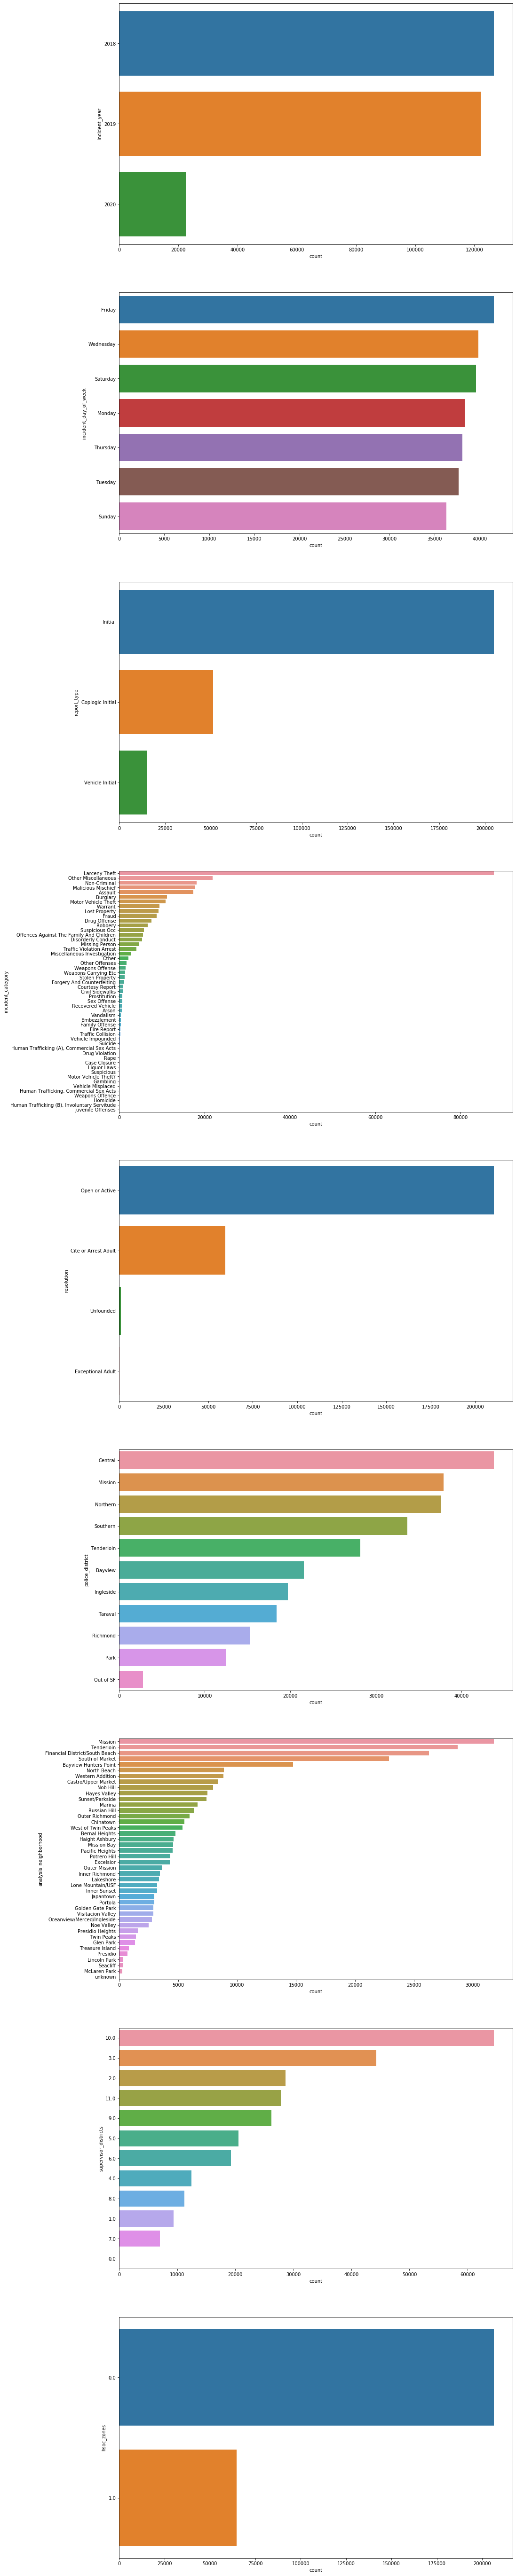

In [820]:
subplot_countplots(reports, cat_features)

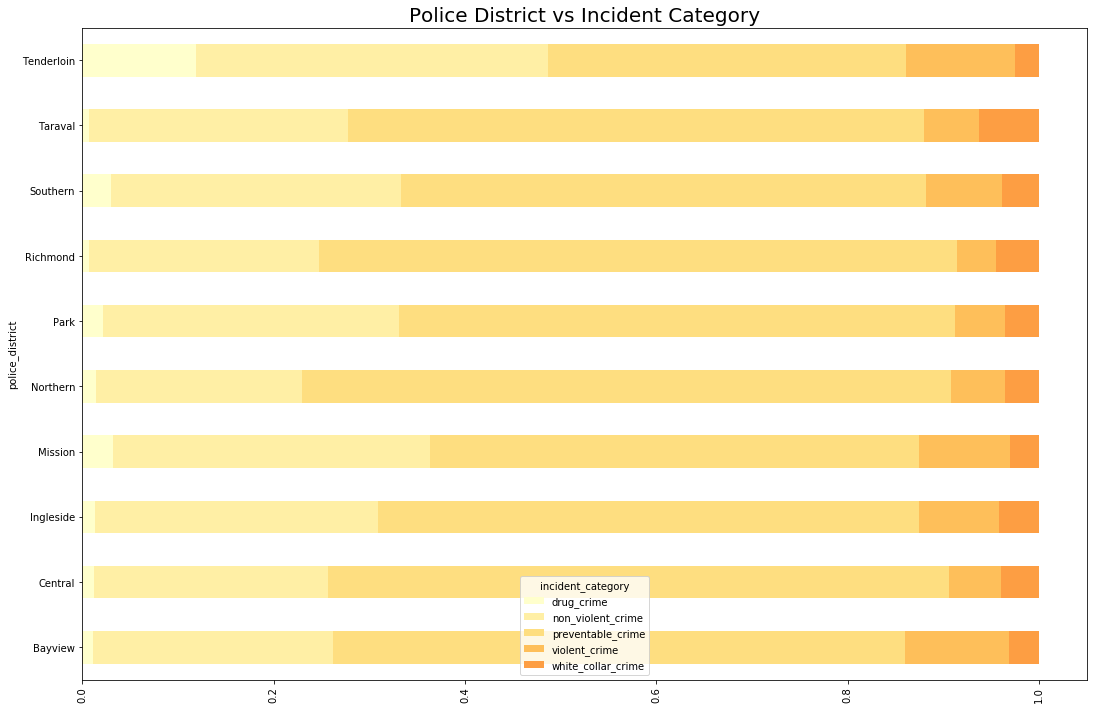

In [887]:
df = pd.crosstab(reports.incident_category, reports.police_district)
color = plt.cm.YlOrRd(np.linspace(0, 1, 10))
df.div(df.sum(1).astype(float), axis = 0).plot.barh(stacked = True, color = color, figsize = (18, 12))
plt.title('Police District vs Incident Category', fontweight = 30, fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

#### Removing incidents that took place out of San Francisco

In 'police_districts', we see that some crimes had taken place outside of SF. We will remove these outlier incidents from our dataset. 

In [822]:
reports.shape

(271378, 13)

In [823]:
#dropping all rows that are supplement reports
reports.drop(reports[reports.police_district.str.contains('Out of SF')].index, inplace=True)

#confirming that the rows have been dropped
reports.shape

(268573, 13)

#### Further understanding and grouping incident categories

There are many incident categories and such level of detail is not necessary. It would be more helpful for Police commanders and policymakers to have the predicted number of crimes grouped by broader and more meaningful categories. 

Based on domain knowledge and research, I have developed the new groups below. Depending on the nature of the crime/incident found in the groups below, different operational and policy tools should be used to address the different groups.

- <U>Preventable crime</U>: such crimes are preventable with increased security presence and/or surveillance (whether through Police, community, and to a lesser extent, cameras) because they happen out in the open or can be easily observed. For example, robbery, burglary or snatch theft are less likely to occur if there is strong police presence in the area, because the culprit knows that he/she could be easily caught immediately after committing the crime. Areas with higher numbers of such crime would easily benefit from increased police patrols or community and tech surveillance measures. 

- <U>Violent crime</U>: such crimes occur less frequently, are of much higher signature, and typically require more advanced investigative resources to solve. They are not as easily preventable as the previous category because they tend to be crimes of passion. Areas with higher numbers of such crime may require specialised resources and measures (combining security, social and economic ones). 

- <U>Drug crime</U>: such crimes have stronger link with social and health issues, and typically recur due to additction. Addressing such crimes include helping victims work on their addictios, and cutting the sources of the drugs. Different policy and operational measures are required to curb such crimes.

- <U>White-collar crime</U>: such crimes e.g. fraud, forgery, are highly premeditated and require specialised detection and investigation resources. As described by FBI, "these crimes are characterized by deceit, concealment, or violation of trust and are not dependent on the application or threat of physical force or violence." Therefore, physical police presence would be insufficient in preventing them. Different policy and operational measures are required to curb such crimes.

- <U>Non-violent crime/incident</U>: for all other crimes/incidents for which increased police presence would not matter, or there are comparatively too few of them to be a distinct group of its own for the purpose of our analysis (this does not mean that the crime is insignificant, only that they are much smaller in number). 

Some of the incident catoegories below can be easily sorted into my new groups. However, there are a few which are not as clear. These are: 'Other Miscellaneous', ‘Warrant’, ‘Suspicious Occ’, ‘Offences Against The Family And Children’, ‘Other Offenses’, and ‘Other’. We will look through the description of each below and decide which group they below to. Thereafter, I will create the new groups for further EDA and subsequent modeling.                                        

In [824]:
#list and count of all unique incident categories
reports.incident_category.value_counts()

Larceny Theft                                 87607
Other Miscellaneous                           21882
Non-Criminal                                  18102
Malicious Mischief                            17802
Assault                                       17376
Burglary                                      11219
Motor Vehicle Theft                           10803
Warrant                                        9412
Lost Property                                  8861
Fraud                                          8441
Drug Offense                                   7563
Robbery                                        6629
Suspicious Occ                                 5655
Offences Against The Family And Children       5554
Disorderly Conduct                             5300
Missing Person                                 4489
Traffic Violation Arrest                       4047
Miscellaneous Investigation                    2653
Other                                          2129
Other Offens

In [825]:
reports2=pd.read_csv('../data/reports.csv')

In [826]:
#standardising column names, replacing the spaces with underscores
#...and converting all letters to lowercase 
reports2.columns = reports2.columns.str.replace(' ', '_').str.lower()

#### Understanding the 'Other Miscellaneous' incident category

Based on the description of incidents found under 'Other Miscellaneous', I will place this category into the non_violent incident group.

In [827]:
other=reports2[['incident_category', 'incident_subcategory', 'incident_description']][reports2['incident_category']=='Other Miscellaneous'] 

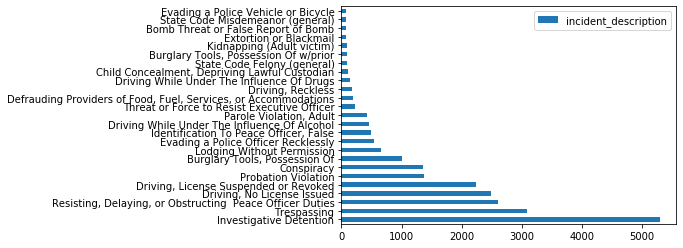

In [828]:
pd.DataFrame(other.incident_description.value_counts()).head(25).plot.barh()

#### Understanding the 'Warrant' incident category

Based on the description of incidents found under 'Warrant', I will place this category into the non_violent incident group. This category appears to be arrest made based on warrants. 

In [829]:
reports2[['incident_category', 'incident_subcategory', 'incident_description']][reports2['incident_category']=='Warrant'] 

,incident_category,incident_subcategory,incident_description
24,Warrant,Other,"Warrant Arrest, Local SF Warrant"
27,Warrant,Other,"Warrant Arrest, Local SF Warrant"
30,Warrant,Other,"Warrant Arrest, Local SF Warrant"
35,Warrant,Other,"Warrant Arrest, Local SF Warrant"
69,Warrant,Warrant,"Warrant Arrest, Enroute To Parole"
...,...,...,...
329268,Warrant,Warrant,"Warrant Arrest, Enroute To Dept. Of Corrections"
329303,Warrant,Other,"Warrant Arrest, Local SF Warrant"
329374,Warrant,Warrant,"Warrant Arrest, Enroute To US Marshall"
329400,Warrant,Warrant,"Warrant Arrest, Enroute To Outside Jurisdiction"


#### Understanding the 'Suspicious Occ' incident category

Based on the description of incidents found under 'Suspicious Occ', I will place this category into the preventable crime group. Such suspicious occurences or persons could be prevented if there were a heavier security presence. 

In [830]:
reports2[['incident_category', 'incident_subcategory', 'incident_description']][reports2['incident_category']=='Suspicious Occ'] 

,incident_category,incident_subcategory,incident_description
71,Suspicious Occ,Suspicious Occ,Suspicious Occurrence
82,Suspicious Occ,Suspicious Occ,Suspicious Occurrence
203,Suspicious Occ,Suspicious Occ,Suspicious Occurrence
209,Suspicious Occ,Suspicious Occ,Suspicious Occurrence
242,Suspicious Occ,Suspicious Occ,Suspicious Occurrence
...,...,...,...
329294,Suspicious Occ,Suspicious Occ,Suspicious Occurrence
329315,Suspicious Occ,Suspicious Occ,Suspicious Occurrence
329363,Suspicious Occ,Suspicious Occ,Suspicious Occurrence
329370,Suspicious Occ,Suspicious Occ,Suspicious Occurrence


#### Understanding the 'Offences Against The Family And Children' incident category

Based on the description of incidents found under 'Offences Against The Family And Children', I will place this category into the preventable crime group. Such demoestic cases of abuse or harassment may be prevented if there were a heavier security presence in the areas.

In [831]:
reports2[['incident_category', 'incident_subcategory', 'incident_description']][reports2['incident_category']=='Offences Against The Family And Children'] 

,incident_category,incident_subcategory,incident_description
0,Offences Against The Family And Children,Other,Domestic Violence (secondary only)
3,Offences Against The Family And Children,Family Offenses,Elder Adult or Dependent Abuse (not Embezzleme...
32,Offences Against The Family And Children,Other,Violation of Stay Away Order
40,Offences Against The Family And Children,Other,Hate Crime (secondary only)
64,Offences Against The Family And Children,Family Offenses,Elder Adult or Dependent Abuse (not Embezzleme...
...,...,...,...
329253,Offences Against The Family And Children,Other,Restraining Order Notification/Service of Rest...
329327,Offences Against The Family And Children,Other,Hate Crime (secondary only)
329398,Offences Against The Family And Children,Other,Domestic Violence (secondary only)
329449,Offences Against The Family And Children,Other,Domestic Violence (secondary only)


#### Understanding the 'Other Offenses' incident category

Based on the description of incidents found under 'Other Offenses', I will place this category into the non_violent incident group.

In [832]:
reports2[['incident_category', 'incident_subcategory', 'incident_description']][reports2['incident_category']=='Other Offenses'] 

,incident_category,incident_subcategory,incident_description
15,Other Offenses,Other,"Alcohol, Consuming In Public View"
19,Other Offenses,Other Offenses,"License Plate, Recovered"
192,Other Offenses,Other,Park Code Violation (general)
460,Other Offenses,Other Offenses,"License Plate, Recovered"
535,Other Offenses,Other Offenses,"License Plate, Recovered"
...,...,...,...
328553,Other Offenses,Other Offenses,"License Plate, Recovered"
328623,Other Offenses,Other Offenses,"License Plate, Recovered"
328626,Other Offenses,Other,"Alcohol, Consuming In Public View"
328925,Other Offenses,Other Offenses,"License Plate, Recovered"


#### Understanding the 'Other' incident category

Based on the description of incidents found under 'Other', I will place this category into the non_violent incident group.

In [833]:
reports2[['incident_category', 'incident_subcategory', 'incident_description']][reports2['incident_category']=='Other'] 

,incident_category,incident_subcategory,incident_description
91,Other,Other,"Death Report, Cause Unknown"
184,Other,Other,"Death Report, Cause Unknown"
253,Other,Other,"Death Report, Cause Unknown"
270,Other,Other,"Death Report, Cause Unknown"
295,Other,Other,"Death Report, Natural Causes"
...,...,...,...
328836,Other,Other,"Death Report, Cause Unknown"
329162,Other,Other,"Death Report, Natural Causes"
329189,Other,Other,"Death Report, Cause Unknown"
329359,Other,Other,"Death Report, Cause Unknown"


#### Grouping incident categories

In [834]:
preventable_crime=['Larceny Theft', 'Malicious Mischief', 'Burglary', 'Motor Vehicle Theft', 
                   'Robbery', 'Stolen Property', 'Disorderly Conduct', 'Vandalism', 'Arson', 
                   'Motor Vehicle Theft?', 'Suspicious Occ', 
                   'Offences Against The Family And Children', 'Suspicious', 
                   'Family Offense', 'Prostitution', 'Civil Sidewalks']

violent_crime=['Assault', 'Weapons Offense', 'Weapons Carrying Etc', 
               'Rape', 'Weapons Offence', 'Homicide']

drug_crime=['Drug Offense', 'Drug Violation']

white_collar_crime=['Fraud', 'Forgery And Counterfeiting', 'Embezzlement']

non_violent_crime=['Lost Property', 'Missing Person', 'Recovered Vehicle', 
                   'Traffic Collision', 'Vehicle Impounded', 'Suicide', 'Vehicle Misplaced', 
                   'Traffic Violation Arrest', 'Non-Criminal', 'Other Miscellaneous', 
                   'Warrant', 'Gambling', 'Human Trafficking, Commercial Sex Acts', 
                   'Human Trafficking (B), Involuntary Servitude', 'Juvenile Offenses', 
                   'Liquor Laws', 'Case Closure', 'Human Trafficking (A), Commercial Sex Acts', 
                   'Fire Report', 'Sex Offense', 'Courtesy Report', 'Other Offenses', 'Other', 
                   'Miscellaneous Investigation']

In [835]:
for i in preventable_crime:
    reports.incident_category.replace({i: 'preventable_crime'}, inplace=True)
    
for i in violent_crime:
    reports.incident_category.replace({i: 'violent_crime'}, inplace=True)

for i in drug_crime:
    reports.incident_category.replace({i: 'drug_crime'}, inplace=True)

for i in white_collar_crime:
    reports.incident_category.replace({i: 'white_collar_crime'}, inplace=True)
    
for i in non_violent_crime:
    reports.incident_category.replace({i: 'non_violent_crime'}, inplace=True)

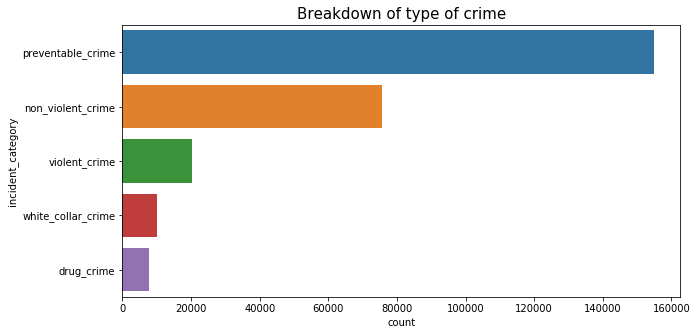

In [836]:
plt.subplots(figsize=(10,5))
plt.title('Breakdown of type of crime', fontsize=15)
sns.countplot(y=reports.incident_category,
             order = reports.incident_category.value_counts().index)

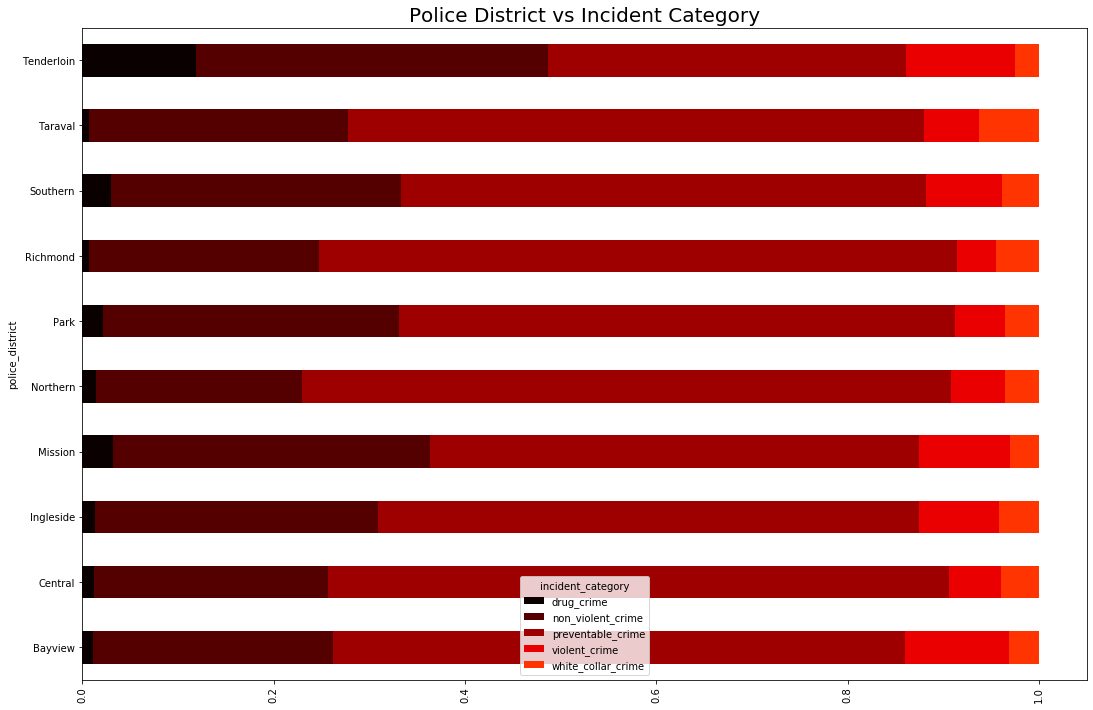

In [889]:
df = pd.crosstab(reports.police_district, reports.incident_category)
color = plt.cm.hot(np.linspace(0, 1, 10))
df.div(df.sum(1).astype(float), axis = 0).plot.barh(stacked = True, color = color, figsize = (18, 12))
plt.title('Police District vs Incident Category', fontweight = 30, fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

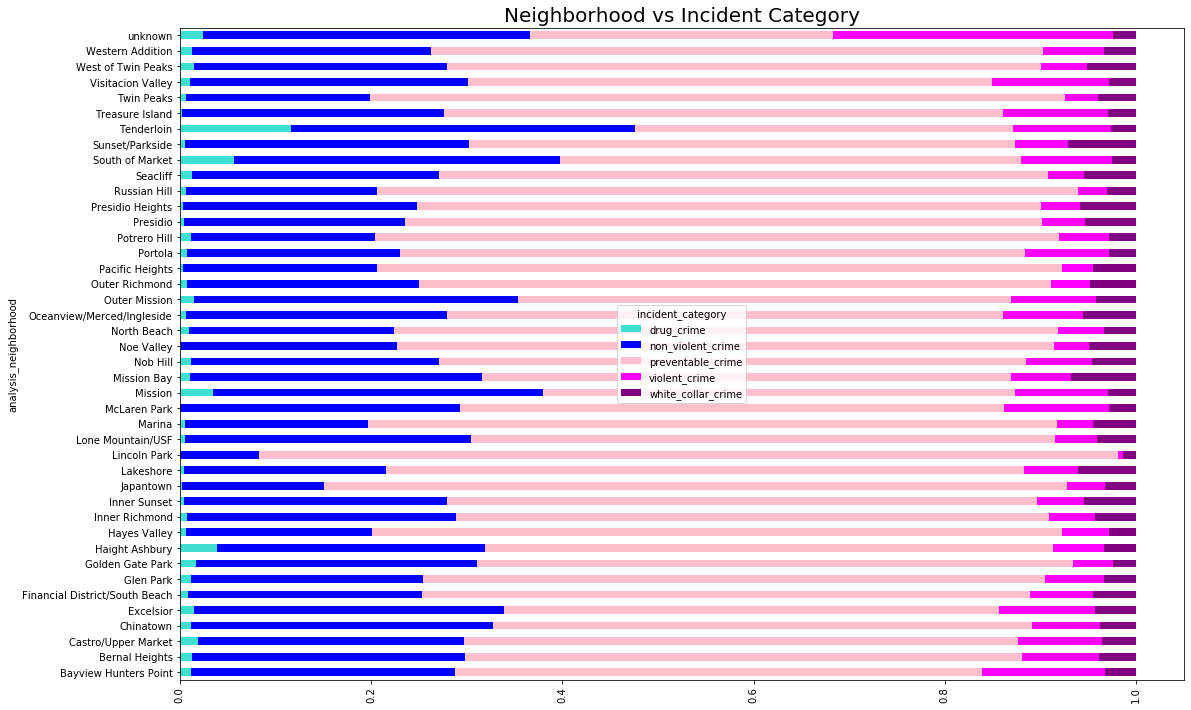

In [899]:
df = pd.crosstab(reports.analysis_neighborhood  , reports.incident_category)
color = ['turquoise','blue','pink','magenta', 'purple']
df.div(df.sum(1).astype(float), axis = 0).plot.barh(stacked = True, color = color, figsize = (18, 12))
plt.title('Neighborhood vs Incident Category', fontweight = 30, fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

In [837]:
#save reports data to csv
reports.to_csv('../data/reports_cleaned.csv', index=False)

### Preprocessing

We will convert longitude and latitude to zipcodes.

In [838]:
reports=pd.read_csv('../data/reports_cleaned.csv')

In [839]:
reports[['latitude', 'longitude']]

,latitude,longitude
0,37.762569,-122.499627
1,37.780535,-122.408161
2,37.797716,-122.430559
3,37.785829,-122.401490
4,37.782488,-122.445821
...,...,...
268568,37.780927,-122.413676
268569,37.766406,-122.424258
268570,37.759830,-122.425920
268571,37.726132,-122.464573


In [840]:
reports['geometry'] = reports.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

In [841]:
geo_police_data = geopandas.GeoDataFrame(reports, geometry='geometry')
geo_police_data.crs = {'init': 'epsg:4326'}

In [842]:
sf = geopandas.read_file('../data/zipcodes.json')
sf.crs = {'init': 'epsg:4326'}
sf = sf.set_geometry('geometry')

In [843]:
reports = geopandas.tools.sjoin(geo_police_data, sf, how='left')

In [844]:
reports.isnull().sum()

incident_date             0
incident_time             0
incident_year             0
incident_day_of_week      0
report_type               0
incident_category         0
resolution                0
police_district           0
analysis_neighborhood     0
latitude                  0
longitude                 0
supervisor_districts      0
hsoc_zones                0
geometry                  0
index_right              60
zip_code                 60
zip                      60
st_area_sh               60
sqmi                     60
state                    60
pop10_sqmi               60
st_length_               60
objectid                 60
po_name                  60
pop2010                  60
id                       60
multigeom                60
dtype: int64

In [863]:
#dropping rows with null values
reports.dropna(inplace=True)

reports.isnull().sum()

incident_date            0
incident_time            0
incident_year            0
incident_day_of_week     0
report_type              0
incident_category        0
resolution               0
police_district          0
analysis_neighborhood    0
latitude                 0
longitude                0
supervisor_districts     0
hsoc_zones               0
geometry                 0
index_right              0
zip_code                 0
zip                      0
st_area_sh               0
sqmi                     0
state                    0
pop10_sqmi               0
st_length_               0
objectid                 0
po_name                  0
pop2010                  0
id                       0
multigeom                0
dtype: int64

In [864]:
reports['zip'].head()

0    94122
1    94103
2    94123
3    94103
4    94115
Name: zip, dtype: object

In [865]:
final_reports=reports[['incident_date', 'incident_day_of_week', 
                       'incident_time', 'zip', 'incident_category']]

In [866]:
final_reports.head()

,incident_date,incident_day_of_week,incident_time,zip,incident_category
0,2019/05/01,Wednesday,01:00,94122,preventable_crime
1,2019/06/22,Saturday,07:45,94103,non_violent_crime
2,2019/05/27,Monday,02:25,94123,violent_crime
3,2018/11/07,Wednesday,03:50,94103,preventable_crime
4,2019/08/15,Thursday,12:45,94115,preventable_crime


In [867]:
final_reports.incident_category.value_counts()

preventable_crime     154868
non_violent_crime      75722
violent_crime          20316
white_collar_crime      9959
drug_crime              7648
Name: incident_category, dtype: int64

In [868]:
final_reports=final_reports[final_reports.incident_category == 'preventable_crime']

In [869]:
final_reports.incident_category.value_counts()

preventable_crime    154868
Name: incident_category, dtype: int64

In [870]:
final_reports.incident_category.replace({'preventable_crime': 1},
                                       inplace=True)

In [871]:
final_reports.rename({'incident_category': 'preventable_crime'}, axis=1, inplace=True)

In [872]:
final_reports.head()

,incident_date,incident_day_of_week,incident_time,zip,preventable_crime
0,2019/05/01,Wednesday,01:00,94122,1
3,2018/11/07,Wednesday,03:50,94103,1
4,2019/08/15,Thursday,12:45,94115,1
9,2019/02/27,Wednesday,15:30,94111,1
11,2019/04/08,Monday,00:30,94115,1


In [873]:
final_reports.loc[:, 'incident_date'] = pd.to_datetime(final_reports['incident_date'])
final_reports.loc[:, 'incident_date'] = final_reports.incident_date.apply(lambda x: x.year)
final_reports.loc[:, 'incident_hour'] = pd.to_datetime(final_reports['incident_time'])
final_reports.loc[:, 'incident_hour'] = final_reports.incident_hour.apply(lambda x: x.hour)

In [874]:
final_reports.head()

,incident_date,incident_day_of_week,incident_time,zip,preventable_crime,incident_hour
0,2019,Wednesday,01:00,94122,1,1
3,2018,Wednesday,03:50,94103,1,3
4,2019,Thursday,12:45,94115,1,12
9,2019,Wednesday,15:30,94111,1,15
11,2019,Monday,00:30,94115,1,0


In [875]:
#save final_reports data to csv
final_reports.to_csv('../data/reports_final.csv', index=False)

#### Splitting into train and test datasets

We will use 2018 data as our training data, and 2019 data as our testing data. We will ignore all 2020 data. 

In [881]:
final_reports.incident_date.value_counts()

2018    71444
2019    70277
2020    13147
Name: incident_date, dtype: int64

In [882]:
#splitting into train and test datasets
train=final_reports[final_reports.incident_date == 2018]
test=final_reports[final_reports.incident_date == 2019]

#dropping incident_date column from both datasets
train.drop('incident_date', axis=1, inplace=True)
test.drop('incident_date', axis=1, inplace=True)

C:\Users\elton\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [883]:
train.shape

(71444, 5)

In [884]:
test.shape

(70277, 5)

In [885]:
#save data to csv
train.to_csv('../data/train.csv', index=False)
test.to_csv('../data/test.csv', index=False)